<a href="https://colab.research.google.com/github/VeraMendes/DS-Unit-2-Applied-Modeling/blob/master/module4/Vera_Mendes_Assignment_applied_modeling_4(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---


# Model Interpretation 2

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make a Shapley force plot to explain at least 1 individual prediction.
- [ ] Share at least 1 visualization (of any type) on Slack.

But, if you aren't ready to make a Shapley force plot with your own dataset today, that's okay. You can practice this objective with another dataset instead. You may choose any dataset you've worked with previously.

## Stretch Goals
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!


## Links
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import shap
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import numpy as np

In [0]:
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

In [0]:
# date_recorded appears as object, change into datetime format
train['date_recorded'] = pd.to_datetime(train['date_recorded'],infer_datetime_format=True)

In [0]:
# Splitting data in a time series manner and making val and test +- same size
test = train[train['date_recorded'] >= '2013-02-11']
train = train[train['date_recorded'] < '2013-02-11']

In [0]:
print(train.shape)
print(test.shape)

(44983, 41)
(14417, 41)


In [0]:
def clean(X):
  # defining one cleaning method for all my data

  # create a copy 
  X = X.copy()

  # values of latitude near zero will be treated as zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # When columns have zeros and shouldn't, they are like null values.
  # So we will replace the zeros with nulls, and impute missing values later.
  cols_to_clean = ['longitude', 'latitude', 'amount_tsh','construction_year',
                   'gps_height', 'permit','public_meeting', 'region_code',
                   'district_code', 'source', 'quantity','quality_group',
                   'payment','water_quality', 'source_class','management',
                   'management_group', 'population','installer','funder',
                   'scheme_management', 'scheme_name']
  for col in cols_to_clean:
    X[col] = X[col].replace(0, np.nan)
    X[col] = X[col].replace('unknown', np.nan)

  # extract year and month of inspection
  X['month_inspection'] = X['date_recorded'].dt.month
  X['year_inspection'] = X['date_recorded'].dt.year

  # extract number of years till inspection
  X['inspection_waiting_time'] = X['year_inspection'] - X['construction_year']

  # binning numeric values
  gps_cut_points = [-63, 250, 1100, 1600, 2770]
  gps_label_names = ['-63-250', '251-1100', '1101-1600', '1601-2700']
  X['gps_height_cat'] = pd.cut(X['gps_height'], gps_cut_points, labels=gps_label_names)

  # quantity & quantity_group same as payment & payment_type are duplicates
  # drop duplicates, date_recorded, less relevance columns and columns used for binning
  X = X.drop(columns=['quantity_group','payment_type','date_recorded', 'recorded_by',
                      'gps_height','construction_year', 'scheme_name', 'num_private'])
  
  #removing status group:functional needs repair
  X = X[X['status_group'] != 'functional needs repair']

  # return my clean function
  return X

train = clean(train)
test = clean(test)


# defining my y vector
target = 'status_group'

# Get my train DF without the target
train_features = train.drop(columns=[target])

# list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

# arranging my X features and y vector
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [0]:
# Save the ids for later, so we can look up actual results,
# to compare with predicted results
train_id = X_train['id']
test_id = X_test['id']

In [0]:
X_train.shape, X_test.shape

((41655, 30), (13428, 30))

In [0]:
train_id.shape, test_id.shape

((41655,), (13428,))

In [0]:
y_train.value_counts(normalize=True)

functional        0.568383
non functional    0.431617
Name: status_group, dtype: float64

In [0]:
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

In [0]:
model = RandomForestClassifier(n_estimators=100,max_depth=21, random_state=42,n_jobs=-1)

In [0]:
X_test_processed = processor.transform(X_test)
class_index = 1
model.fit(X_train_processed, y_train)
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Val ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Val ROC AUC for class 1:
0.8224279111744037


In [0]:
X_test.head()

,id,amount_tsh,longitude,latitude,region_code,district_code,population,month_inspection,year_inspection,inspection_waiting_time,basin,region,public_meeting,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,gps_height_cat
1,8776,NaN,34.698766,-2.147466,20,2,280.0,3,2013,3.0,Lake Victoria,Mara,NaN,Other,True,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1101-1600
2,34310,25.0,37.460664,-3.821329,21,4,250.0,2,2013,4.0,Pangani,Manyara,True,VWC,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,251-1100
11,50409,200.0,35.770258,-10.574175,10,5,250.0,2,2013,26.0,Lake Nyasa,Ruvuma,True,WUG,NaN,swn 80,swn 80,handpump,wug,user-group,pay when scheme fails,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,251-1100
13,50495,NaN,37.092574,-3.181783,3,7,1.0,3,2013,4.0,Pangani,Kilimanjaro,True,Water Board,True,gravity,gravity,gravity,water board,user-group,pay monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1101-1600
23,37862,500.0,37.940029,-4.125595,3,3,210.0,11,2013,2.0,Pangani,Kilimanjaro,True,Water authority,True,gravity,gravity,gravity,vwc,user-group,pay monthly,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,251-1100


In [0]:
df = pd.DataFrame({
    'id': test_id,
    'pred_proba': y_pred_proba, 
    'status_group': y_test
})

df = df.merge(
     X_test[['id','amount_tsh', 'longitude', 'latitude', 'region_code', 'quantity', 'waterpoint_type']]
)

In [0]:
functional = df['status_group'] == 'functional'
non_functional = ~functional
right = (functional) == (df['pred_proba'] > 0.50)
wrong = ~right

In [0]:
df[functional & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id,pred_proba,status_group,amount_tsh,longitude,latitude,region_code,quantity,waterpoint_type
10240,31645,0.509392,functional,50.0,39.433682,-7.097917,7,insufficient,communal standpipe
9946,46907,0.539153,functional,NaN,40.256577,-10.575746,99,enough,hand pump
4472,56638,0.543843,functional,NaN,37.480301,-3.363495,3,NaN,communal standpipe
13245,34250,0.561667,functional,50.0,35.445791,-10.638419,10,enough,communal standpipe
10168,825,0.566704,functional,500.0,35.861901,-10.551764,10,insufficient,hand pump
11493,53154,0.570000,functional,NaN,37.585355,-3.260990,3,insufficient,communal standpipe
8418,41675,0.578942,functional,NaN,37.352299,-3.288068,3,insufficient,communal standpipe
11495,39336,0.639812,functional,NaN,37.535703,-3.310425,3,insufficient,other
9804,26023,0.653544,functional,NaN,36.836372,-3.310177,2,insufficient,communal standpipe
5702,48535,0.810214,functional,NaN,35.079186,-10.800198,10,dry,communal standpipe


In [0]:
# To explain the prediction for test observation with index #10168,
# first, get all of the features for that observation
row = X_test.iloc[[10168]]

In [0]:
row

,id,amount_tsh,longitude,latitude,region_code,district_code,population,month_inspection,year_inspection,inspection_waiting_time,basin,region,public_meeting,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,gps_height_cat
45038,825,500.0,35.861901,-10.551764,10,5,360.0,2,2013,14.0,Rufiji,Ruvuma,True,WUG,NaN,other - swn 81,other handpump,handpump,wug,user-group,pay monthly,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,251-1100


In [0]:
explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)
#print(shap_values)
shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row
)


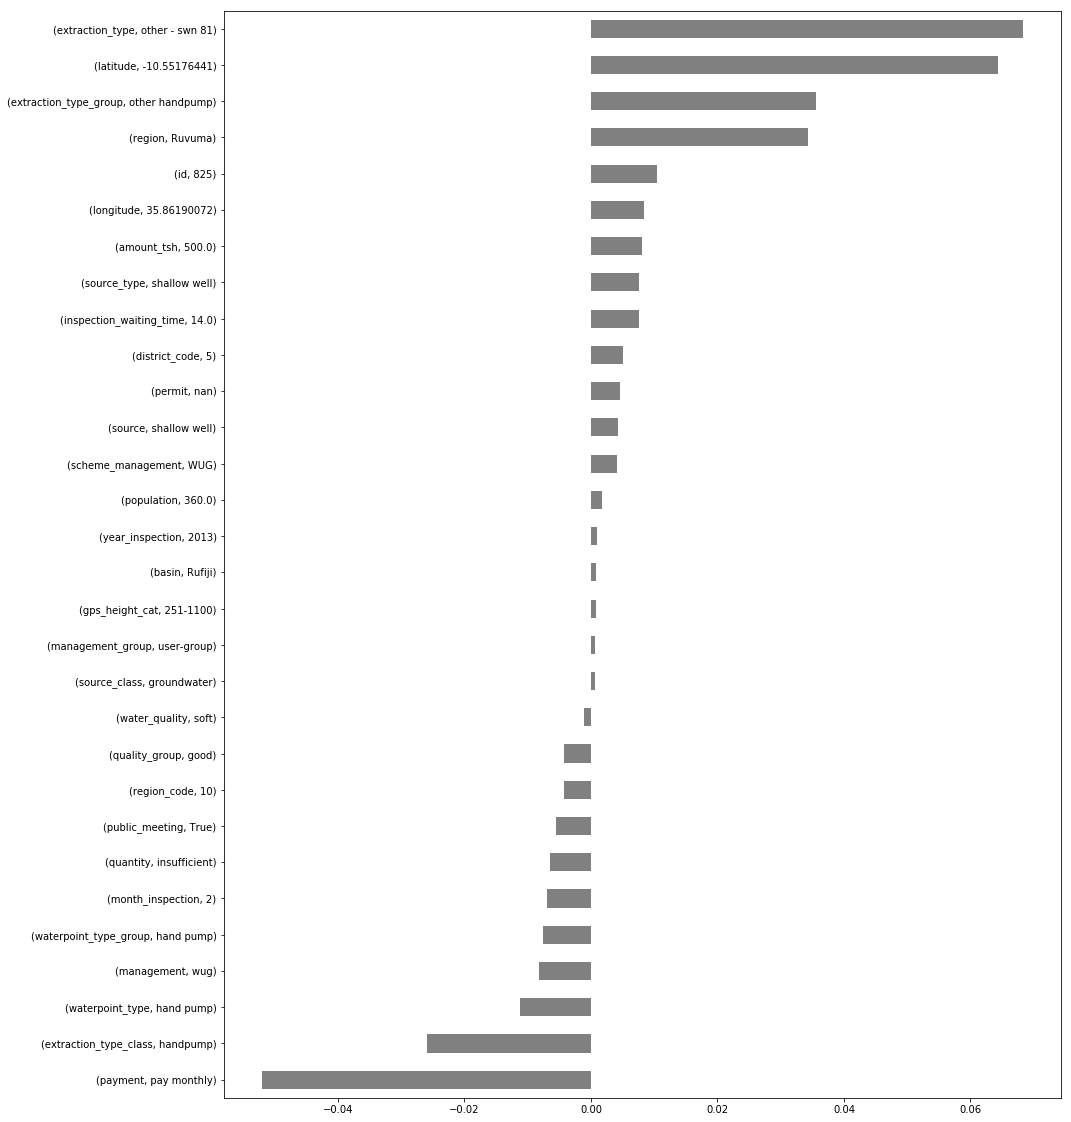

In [0]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[1][0], zip(feature_names, feature_values))
shaps.sort_values().plot.barh(color='grey', figsize=(15,20));


In [0]:
pros = shaps.sort_index(ascending=False).index[:3]
cons = shaps.sort_index(ascending=True).index[:3]
print(pros)
print(cons)

Index([             ('year_inspection', 2013),
       ('waterpoint_type_group', 'hand pump'),
             ('waterpoint_type', 'hand pump')],
      dtype='object')
Index([('amount_tsh', 500.0), ('basin', 'Rufiji'), ('district_code', 5)], dtype='object')


In [0]:
print('Top 3 reasons for prediction:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} is {feature_value}.')

print('\n')
print('Cons:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} is {feature_value}.')

Top 3 reasons for prediction:
1. year_inspection is 2013.
2. waterpoint_type_group is hand pump.
3. waterpoint_type is hand pump.


Cons:
1. amount_tsh is 500.0.
2. basin is Rufiji.
3. district_code is 5.


# to review

In [0]:
def explain(row_number):
  positive_class = 'functional'
  positive_class_index = 1

  # data for the row
  row = X_test.iloc[[row_number]]
  print(row)
  row_processed = processor.transform(row)
  #print(row_processed)
  # predictions
  pred = model.predict(row_processed)[0]
  #print(model.predict(row_processed))
  pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
  pred_proba*=100
  if pred!=positive_class:
    pred_proba=100-pred_proba

  # prediction and probability
  print(f'The model predicts this water pump is {pred}, with {pred_proba:.0f}% probability.')

  # shapley explanation
  shap_values = explainer.shap_values(row_processed)
  
  # 3 top cons and pros
  feature_names = row.columns
  feature_values = row.values[0]
  shaps= pd.Series(shap_values[1][0], zip(feature_names, feature_values))
  pros = shaps.sort_index(ascending=False).index[:3]
  #print(pros)
  cons = shaps.sort_index(ascending=True).index[:3]
  #print(cons)

  # Show top 3 reasons for prediction
  print('\n')
  print('Top 3 reasons for prediction:')
  evidence = pros if pred == positive_class else cons
  for i, info in enumerate(evidence, start=1):
    #feature_value, feature_name = info
    feature_name, feature_value = info
    print(f'{i}. {feature_name} is {feature_value}.')
  
  # Show top 1 counter-argument against prediction
  print('\n')
  print('Top counter-argument against prediction:')
  evidence = cons if pred == positive_class else pros
  feature_name, feature_value = evidence[0]
  print(f'-> {feature_name} is {feature_value}.')

  # # shapley
  shap.initjs()
  return shap.force_plot(
      base_value=explainer.expected_value[1], 
      shap_values=shap_values[1], 
      features=row
  ) 

explain(10168)

        id  amount_tsh  ...  waterpoint_type_group  gps_height_cat
45038  825       500.0  ...              hand pump        251-1100

[1 rows x 30 columns]
The model predicts this water pump is non functional, with 43% probability.


Top 3 reasons for prediction:
1. amount_tsh is 500.0.
2. basin is Rufiji.
3. district_code is 5.


Top counter-argument against prediction:
-> year_inspection is 2013.


In [0]:
z = X_test.id == 825
X_test[z]



,id,amount_tsh,longitude,latitude,region_code,district_code,population,month_inspection,year_inspection,inspection_waiting_time,basin,region,public_meeting,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,gps_height_cat
45038,825,500.0,35.861901,-10.551764,10,5,360.0,2,2013,14.0,Rufiji,Ruvuma,True,WUG,NaN,other - swn 81,other handpump,handpump,wug,user-group,pay monthly,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,251-1100


In [0]:
df[non_functional & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id,pred_proba,status_group,amount_tsh,longitude,latitude,region_code,quantity,waterpoint_type
11181,57311,0.204882,non functional,NaN,33.555414,-2.878328,17,seasonal,communal standpipe
10243,41979,0.232196,non functional,NaN,36.780295,-3.558382,2,insufficient,communal standpipe
10593,28675,0.264124,non functional,NaN,35.843673,-3.343637,2,enough,communal standpipe
11843,51614,0.313315,non functional,NaN,37.921060,-4.181960,3,enough,communal standpipe
6397,4800,0.325768,non functional,20.0,36.821175,-3.489659,2,insufficient,communal standpipe
5421,48365,0.364687,non functional,1000.0,37.815060,-4.394114,3,insufficient,communal standpipe
9251,924,0.429485,non functional,NaN,36.904811,-3.421416,2,insufficient,communal standpipe
12462,51328,0.432533,non functional,NaN,35.944699,-3.206362,2,insufficient,communal standpipe
4522,33769,0.453798,non functional,300.0,37.567833,-3.700128,3,insufficient,other
83,56863,0.492432,non functional,2000.0,36.043840,-10.991834,10,insufficient,hand pump


In [0]:
explain(83)

The model predicts this water pump is functional, with 49% probability.


Top 3 reasons for prediction:
1. year_inspection is 2013.
2. waterpoint_type_group is hand pump.
3. waterpoint_type is hand pump.


Top counter-argument against prediction:
-> amount_tsh is 2000.0.


In [0]:
df[functional & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id,pred_proba,status_group,amount_tsh,longitude,latitude,region_code,quantity,waterpoint_type
4821,72575,0.027148,functional,NaN,NaN,NaN,17,enough,hand pump
8740,21912,0.172905,functional,NaN,35.418288,-4.381465,21,insufficient,communal standpipe
1231,62527,0.205121,functional,NaN,37.710216,-3.778196,3,enough,communal standpipe
2054,60499,0.233635,functional,200.0,36.785844,-2.546310,2,insufficient,communal standpipe
3259,34261,0.270000,functional,NaN,37.103075,-3.213831,3,enough,communal standpipe
7062,30357,0.316444,functional,2500.0,36.964114,-11.304807,10,enough,hand pump
6334,16049,0.358722,functional,NaN,36.786867,-4.875636,21,seasonal,communal standpipe
9392,3510,0.375564,functional,50.0,36.689984,-3.362850,2,insufficient,communal standpipe
3875,35204,0.399839,functional,NaN,36.857780,-3.182626,2,insufficient,communal standpipe
1756,1970,0.416978,functional,500.0,36.025360,-10.535191,10,insufficient,communal standpipe multiple


In [0]:
explain(1756)

The model predicts this water pump is functional, with 42% probability.


Top 3 reasons for prediction:
1. year_inspection is 2013.
2. waterpoint_type_group is communal standpipe.
3. waterpoint_type is communal standpipe multiple.


Top counter-argument against prediction:
-> amount_tsh is 500.0.


In [0]:
df[non_functional & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id,pred_proba,status_group,amount_tsh,longitude,latitude,region_code,quantity,waterpoint_type
10951,4011,0.583333,non functional,NaN,37.458575,-10.966449,10,enough,communal standpipe
9669,49385,0.590000,non functional,NaN,34.180999,-2.954582,17,NaN,hand pump
2860,63616,0.622140,non functional,50.0,39.168197,-6.749737,7,dry,communal standpipe
9226,18659,0.746345,non functional,50.0,35.183274,-4.656745,21,dry,communal standpipe
10887,9085,0.759000,non functional,NaN,37.405413,-3.400201,3,insufficient,other
7076,44472,0.849091,non functional,NaN,35.522209,-9.527207,10,dry,hand pump
4791,47531,0.850000,non functional,NaN,34.651365,-11.082657,10,dry,communal standpipe
928,13547,0.890000,non functional,NaN,39.011788,-10.492600,90,dry,communal standpipe
45,33169,0.926098,non functional,NaN,33.277344,-4.201366,14,seasonal,other
6803,25188,0.997391,non functional,NaN,34.592179,-4.531287,13,enough,other


In [0]:
explain(6803)

The model predicts this water pump is non functional, with 0% probability.


Top 3 reasons for prediction:
1. amount_tsh is nan.
2. basin is Internal.
3. district_code is 1.


Top counter-argument against prediction:
-> year_inspection is 2013.


In [0]:
X_test_processed = pd.DataFrame(X_test_processed, columns=X_test.columns)

In [0]:
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_test_processed, y_test)

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=21,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                       

In [0]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

quantity                   0.093119
inspection_waiting_time    0.028612
population                 0.010605
payment                    0.005183
waterpoint_type_group      0.003664
public_meeting             0.003232
waterpoint_type            0.003128
amount_tsh                 0.003083
management_group           0.001877
region                     0.001534
district_code              0.000983
source_type                0.000789
basin                      0.000715
quality_group              0.000581
month_inspection           0.000417
extraction_type            0.000089
year_inspection            0.000000
source_class              -0.000060
id                        -0.000283
permit                    -0.000402
region_code               -0.000492
water_quality             -0.000566
scheme_management         -0.000670
extraction_type_class     -0.001087
latitude                  -0.001445
source                    -0.001475
gps_height_cat            -0.001743
management                -0

In [0]:
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.0931 ± 0.0036,quantity
0.0286 ± 0.0024,inspection_waiting_time
0.0106 ± 0.0018,population
0.0052 ± 0.0023,payment
0.0037 ± 0.0019,waterpoint_type_group
0.0032 ± 0.0011,public_meeting
0.0031 ± 0.0013,waterpoint_type
0.0031 ± 0.0013,amount_tsh
0.0019 ± 0.0005,management_group
0.0015 ± 0.0009,region


In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_type',
                                      'source_class', 'waterpoint_type',
                                      'waterpoint_t...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_s

In [0]:
y_pred = pipeline.predict(X_test)
print('Validation Accuracy', accuracy_score(y_test, y_pred))

Validation Accuracy 0.7817247542448614


In [0]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

X_train.shape, X_test.shape, X_train_encoded.shape, X_test_encoded.shape

((41655, 30), (13428, 30), (41655, 30), (13428, 30))

In [0]:
eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

model = XGBClassifier(
    n_estimators=1000, # <= 1000 trees, depends on early stopping
    max_depth=6,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.1, # try higher learning rate
    n_jobs=-1
)

model.fit(X_train_encoded, y_train, eval_set=eval_set, 
          eval_metric='mae', early_stopping_rounds=50)

[0]	validation_0-mae:0.480748	validation_1-mae:0.484978
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.463652	validation_1-mae:0.470435
[2]	validation_0-mae:0.447976	validation_1-mae:0.458276
[3]	validation_0-mae:0.434187	validation_1-mae:0.446616
[4]	validation_0-mae:0.421242	validation_1-mae:0.436962
[5]	validation_0-mae:0.409601	validation_1-mae:0.428073
[6]	validation_0-mae:0.399047	validation_1-mae:0.419387
[7]	validation_0-mae:0.389409	validation_1-mae:0.41239
[8]	validation_0-mae:0.380928	validation_1-mae:0.405827
[9]	validation_0-mae:0.372468	validation_1-mae:0.401177
[10]	validation_0-mae:0.364821	validation_1-mae:0.39555
[11]	validation_0-mae:0.357923	validation_1-mae:0.390676
[12]	validation_0-mae:0.352065	validation_1-mae:0.386384
[13]	validation_0-mae:0.346271	validation_1-mae:0.381297
[14]	validation_0-mae:0.341707	validation_1-mae:0.378413


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

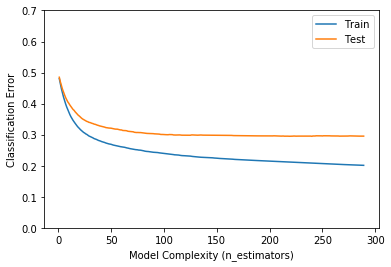

In [0]:
results = model.evals_result()
train_error = results['validation_0']['mae']
test_error = results['validation_1']['mae']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, test_error, label='Test')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.0, 0.7)) # Zoom in
plt.legend();